In [1]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to reconstruct MR images and how to apply filters 
# in k-space.
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of May 2017
# Updated: 1st of April 2019
# Author: Christoph Kolbitsch, Johannes Mayer
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR
from sirf.Utilities import examples_data_path

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt

#%% GO TO MR FOLDER
os.chdir( examples_data_path('MR'))




Using matplotlib backend: Qt5Agg


### K-space Filtering
#### Goals of this notebook:
- Definition of our own function in Python.
- Write first lines of code.
- Extraction of the k-space data stored in the AcquisitionData objects.
- Application of a filter to the k-space data.
- Obtain a better understanding of the relationship between k-space and image space.

### Programming task
Now it's time to apply some of our Python knowledge in a minimal programming exercise.
Please write code which completes the following task:
- create a variable named `acq_data` of the class `AcquisitionData` of the `pMR` package.
- the file we want to load is called `ptb_resolutionphantom_fully_ismrmrd.h5`. Pass this as the argument to the constructor of `AcquisitionData`.
- create a variable named `kdim` and assign it the return value of the method  `dimensions` of `AcquisitionData`. `dimensions` does not take arguments.

__Please make sure the variable names are as indicated.__

In [2]:
# YOUR CODE GOES HERE





In [3]:
# AS A TEST RUN THIS CELL:
print('Size of k-space %dx%dx%d' % kdim)


NameError: name 'kdim' is not defined

In [4]:
# SOLUTION CELL.
# DON'T RUN UNLESS YOU TRIED TO WRITE YOUR OWN CODE FIRST.
































acq_data = pMR.AcquisitionData('ptb_resolutionphantom_fully_ismrmrd.h5')

kdim = acq_data.dimensions()
print('Size of k-space %dx%dx%d' % kdim)




Size of k-space 256x4x512


### Question Data Dimensions:
- Have a quick guess what the different dimensions of the data represent.

In [5]:
#%% PREPROCESS DATA 
# Remember, this will correct for asymmetric echoes, noise correlation and removal of readout oversampling.
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)

# Get size of k-space data after removal of oversampling
kdim = preprocessed_data.dimensions()
print('Size of k-space %dx%dx%d' % kdim)




Size of k-space 256x4x256


### Question Data Dimensions:
- Have an _educated_ guess what the different dimensions of the data represent.

### Image Filter
To filter our image we can use the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).  
It states that for two functions $f, g$ and their Fourier transforms $F = \mathcal{F}(f), G = \mathcal{F}(g)$ the following relation holds:  

$$ 
\mathcal{F}(f * g) = F \cdot G
$$

"Filtering an image" means to perform a convolution of the image with a filter function. This will weight each image pixel with it's neighbouring pixels by weight of the filter.  

Using the convolution theorem we don't need to actually convolve our image, we can simply multiply our k-space data with the Fourier transform of the filter and achieve the same effect.

### A note on Python programming
To define our own function, Python requires the following syntax:
``` 
def function_name( argument1, argument2, ... , argumentN):
    something = code_that_does_something_with_arguments
    
    return something
``` 
__Indentation is important in Python!__  

In [6]:
#%% a definition of a Gaussian function
# the numpy package is a powerful algebra package allowing for fast computations of multidimensional arrays
def gaussian(x, mu, sigma):
    return numpy.exp(-numpy.power(x - mu, 2.) / (2 * numpy.power(sigma, 2.)))





In [7]:
#%% CREATE K-SPACE FILTER
# Set width of Gaussian weighting function
sigma = 5.0

kx_axis = numpy.array([numpy.linspace(-kdim[2]/2, kdim[2]/2, kdim[2])])


# We call our gaussian function
gauss_1d = gaussian(kx_axis ,  0,sigma)

# Extend 1D weighting function to 2D by repeating it along the phase encoding 
# dimension
gauss_weight = numpy.tile(gauss_1d, (kdim[0], 1))

In [8]:
#%% APPLY K-SPACE FILTER
# Retrieve k-space data
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)
preprocessed_array = preprocessed_data.as_array()



# Apply 2D weighting function to each coil
for c in range(kdim[1]):
    preprocessed_array[:,c,:] = numpy.multiply(preprocessed_array[:,c,:], gauss_weight)
    
# Update modified k-space data    
preprocessed_data.fill(preprocessed_array)

In [9]:
#%% RECONSTRUCT IMAGES
recon = pMR.FullySampledReconstructor()
recon.set_input(preprocessed_data)
recon.process()




[0, 255, 0, 1]

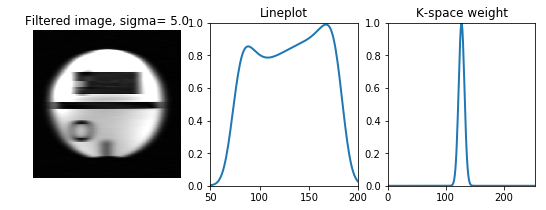

In [10]:
#%% RETRIEVE AND VIEW IMAGE
image_data = recon.get_output()
image_array = abs(image_data.as_array())
image_array = image_array/image_array.max()

fig = plt.figure(figsize=[9, 3])
plt.set_cmap('gray')
ax = fig.add_subplot(1,3,1)
ax.imshow(image_array[0,:,:], vmin=0, vmax=0.7)
ax.set_title('Filtered image, sigma= ' + str(sigma))
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.plot(image_array[0,50,:], linewidth=2.0)
ax.set_title('Lineplot')
plt.axis([50, 200, 0, 1])

ax = fig.add_subplot(1,3,3)
ax.plot(gauss_1d[0,:], linewidth=2.0)
ax.set_title('K-space weight')
plt.axis([0, 255, 0, 1])


### Question:
What happened compared to the dataset we looked at earlier?
What are your expectations if you increase the width of the k-space weights?  
For a __larger__ width, will the smoothing effect become:
- stronger
- or weaker?


### Programming task
Go back to the cell in which the filter width `sigma` is defined.
- Vary `sigma` and run the all the next cells to get an update of the plot.
- view the resulting reconstructions 
- repeat this for different widths between 1 and 100.


### Question:
What happens for:
- larger filter widths?
- smaller filter widths?

Did this match your expectations?

In [ ]:
plt.close('all')

### Recap
#### We just learned
- to access data stored in AcquisitionData objects.
- which data dimensions correspond to which encoding steps.
- how to define a Python function.
- about the convolution theorem.
- to filter an image by weighting its k-space.
- about the reciprocal nature of lengths in k-space and image space.
